In [189]:
import numpy as np
import random
import operator
import pandas as pd
import time
import math
import copy
import seaborn as sns
import networkx as nx
import os
import warnings
warnings.filterwarnings("ignore")       
import matplotlib.pyplot as plt

import re

file_path = "#sgb128_dist.txt"


Buoc 1: Khoi tao quan the

In [190]:
def init(pop_size, n):
    population = []
    for _ in range(pop_size):
        individual = list(range(n))
        individual = random.sample(individual, len(individual))
        population.append(individual)
    return population


Buoc 2: Ham thich nghi

In [191]:
def fitness(individual, distance_matrix):
    total_distance = 0.0
    for i in range(len(individual)):
        a = individual[i]
        b = individual[(i + 1) % len(individual)]
        total_distance += distance_matrix[a][b]
    return total_distance

Buoc 3: Lai ghep

In [192]:
def crossOver(parent1, parent2):
    size = len(parent1)
    point1 = random.randint(0, size - 1)
    point2 = size - point1
    child1 = parent1[:point1] + parent2[point2:]
    child2 = parent2[:point2] + parent1[point1:]
    return child1, child2

Buoc 3: Dot bien

In [193]:
def mutate(individual):
    size = len(individual)
    if size < 2:
        return individual  # Không làm gì nếu rỗng hoặc chỉ có 1 gene
    i, j = random.sample(range(size), 2)
    individual[i], individual[j] = individual[j], individual[i]
    return individual


Buoc 4: Thiet ke vong lap mainloop

In [194]:
def nextPopulation(population, distance_matrix, pop_size, cross_rate, mutate_rate):
    size = len(population[0])

    # helper repair: giữ xuất hiện đầu tiên, thêm các giá trị thiếu
    def _repair_permutation(child, size):
        out = []
        seen = set()
        for x in child:
            try:
                xi = int(x)
            except Exception:
                continue
            if 0 <= xi < size and xi not in seen:
                out.append(xi)
                seen.add(xi)
        # thêm các giá trị còn thiếu
        for v in range(size):
            if v not in seen:
                out.append(v)
        return out[:size]

    # tạo offspring
    offspring = []
    # để tránh vòng lặp vô hạn, giới hạn số vòng lớn nhất (phòng trường hợp cross/mutate hỏng)
    max_trials = pop_size * 10
    trials = 0
    while len(offspring) < pop_size and trials < max_trials:
        trials += 1
        parent1 = random.choice(population)
        parent2 = random.choice(population)
        if random.random() < cross_rate:
            child1, child2 = crossOver(parent1, parent2)
        else:
            child1, child2 = copy.copy(parent1), copy.copy(parent2)

        # apply mutate (dùng mutate của bạn)
        if random.random() < mutate_rate:
            child1 = mutate(child1)
        if random.random() < mutate_rate:
            child2 = mutate(child2)

        # repair để là permutation hợp lệ
        child1 = _repair_permutation(child1, size)
        child2 = _repair_permutation(child2, size)

        offspring.append(child1)
        if len(offspring) < pop_size:
            offspring.append(child2)

    # kết hợp parent + offspring, chọn top pop_size theo fitness
    combined = [copy.copy(p) for p in population] + offspring

    # tính fitness cho mỗi cá thể trong combined
    combined_scores = [(ind, fitness(ind, distance_matrix)) for ind in combined]
    combined_scores.sort(key=lambda x: x[1])  # tăng dần (fitness nhỏ tốt)

    # lấy top pop_size cá thể tốt nhất
    new_population = [copy.copy(ind) for ind, _ in combined_scores[:pop_size]]

    return new_population


Buoc 5: Thuat taon GA

In [195]:
def geneticAlgorithm(file_path, pop_size, cross_rate, mutate_rate, max_iter, elitism=1):
    # Đọc file thành ma trận vuông
    with open(file_path, "r") as f:
        lines = f.readlines()

    data = []
    for line in lines:
        line = line.strip()
        if not line:
            continue
        try:
            nums = list(map(float, line.split()))
            data.append(nums)
        except ValueError:
            continue

    distance_matrix = np.array(data)

    # Kiểm tra nếu không vuông thì cắt/gộp cho đúng
    n_rows, n_cols = distance_matrix.shape
    if n_rows != n_cols:
        min_size = min(n_rows, n_cols)
        distance_matrix = distance_matrix[:min_size, :min_size]
        print(f"⚠ Ma trận không vuông, đã cắt về kích thước {min_size}×{min_size}")

    n = len(distance_matrix)

    # Khởi tạo quần thể
    population = init(pop_size, n)
    best_individual = None
    best_fitness = float('inf')
    fitness_history = []

    for gen in range(1, max_iter + 1):
        # tạo thế hệ mới
        population = nextPopulation(population, distance_matrix, pop_size, cross_rate, mutate_rate)

        # tính điểm fitness cho từng cá thể
        fitness_scores = [(individual, fitness(individual, distance_matrix)) for individual in population]
        fitness_scores.sort(key=lambda x: x[1])

        current_best_individual, current_best_fitness = fitness_scores[0]
        fitness_history.append(current_best_fitness)

        if current_best_fitness < best_fitness:
            best_fitness = current_best_fitness
            best_individual = current_best_individual.copy()

        print(f"Gen {gen}: best fitness = {current_best_fitness:.4f} (overall best = {best_fitness:.4f})")

    # Vẽ biểu đồ
    plt.figure(figsize=(8,4))
    plt.plot(range(1, len(fitness_history) + 1), fitness_history, linewidth=1)
    plt.xlabel('Generation')
    plt.ylabel('Best fitness')
    plt.title('Fitness over generations')
    plt.grid(True)
    plt.show()


    return best_individual, best_fitness


Gen 1: best fitness = 138309.0000 (overall best = 138309.0000)
Gen 2: best fitness = 131217.0000 (overall best = 131217.0000)
Gen 3: best fitness = 131217.0000 (overall best = 131217.0000)
Gen 4: best fitness = 131217.0000 (overall best = 131217.0000)
Gen 5: best fitness = 130460.0000 (overall best = 130460.0000)
Gen 6: best fitness = 130460.0000 (overall best = 130460.0000)
Gen 7: best fitness = 129448.0000 (overall best = 129448.0000)
Gen 8: best fitness = 128443.0000 (overall best = 128443.0000)
Gen 9: best fitness = 127871.0000 (overall best = 127871.0000)
Gen 10: best fitness = 125742.0000 (overall best = 125742.0000)
Gen 11: best fitness = 122965.0000 (overall best = 122965.0000)
Gen 12: best fitness = 122965.0000 (overall best = 122965.0000)
Gen 13: best fitness = 122965.0000 (overall best = 122965.0000)
Gen 14: best fitness = 122525.0000 (overall best = 122525.0000)
Gen 15: best fitness = 121235.0000 (overall best = 121235.0000)
Gen 16: best fitness = 121054.0000 (overall best 

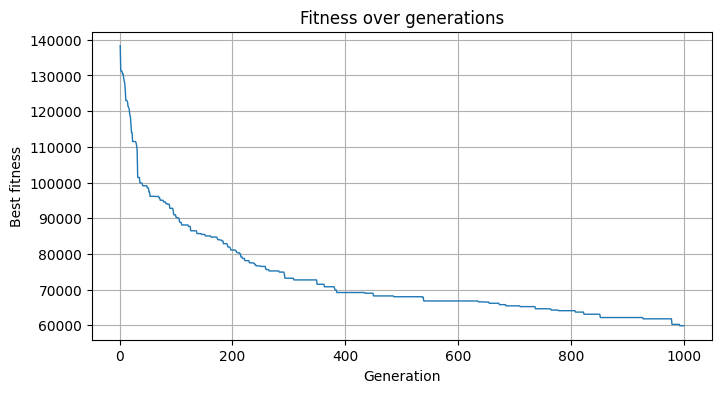

Best individual: [17, 30, 29, 74, 34, 100, 126, 110, 31, 1, 123, 94, 55, 39, 117, 118, 121, 122, 124, 79, 116, 85, 125, 127, 89, 103, 3, 92, 5, 6, 7, 9, 98, 10, 11, 12, 13, 105, 53, 44, 95, 19, 23, 15, 20, 22, 24, 25, 26, 64, 40, 49, 33, 83, 35, 36, 37, 48, 18, 50, 51, 54, 115, 56, 2, 90, 91, 86, 8, 101, 102, 106, 96, 107, 4, 93, 61, 60, 119, 57, 58, 66, 62, 63, 70, 72, 108, 88, 0, 21, 16, 77, 46, 47, 43, 82, 65, 32, 67, 84, 68, 69, 38, 104, 113, 71, 28, 42, 27, 41, 45, 80, 81, 14, 97, 99, 78, 75, 76, 109, 87, 111, 52, 120, 59, 73, 112, 114]
Best fitness: 59903.0


In [196]:
best_individual, best_fitness = geneticAlgorithm(
    "#sgb128_dist.txt", 
    100, 0.7, 0.1, 1000, elitism=2
)
print("Best individual:", best_individual)
print("Best fitness:", best_fitness)